In [4]:
import casadi as ca
import chaospy as cp
import numpy as np

In [5]:
def generate_pce_basis_and_quadrature(pce_order, k_mean=1.0, k_std=0.25):
    dist = cp.Normal(k_mean, k_std)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule="gaussian")
    nodes = nodes.flatten()
    weights = weights.flatten()
    M = len(nodes)
    basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    Psi_mat = np.array([[float(basis[j](nodes[i])) for j in range(M)] for i in range(M)])
    Psi_dm = ca.DM(Psi_mat)
    weights_dm = ca.DM(weights.reshape(1, -1))
    return nodes, weights, Psi_dm, weights_dm

In [ ]:

def solve_ocp_pce_nlp(pce_order=5, k_mean=1.0, k_std=0.25):
    tf = 40
    N = 80
    dt = tf / N

    m, g, delta = 4662, 32.172, 0.03491
    A0, A1, A2 = 0.4456e5, -0.2398e2, 0.1442e-1
    rho, S = 0.2203e-2, 0.1560e4
    beta0, beta_dot0, sigma = 0.4, 0.2, 3
    B0, B1, B2 = 0.1552, 0.12369, 2.4203
    C0, C1, C2 = 0.7125, 6.0877, -9.0277
    umax, alphamax, alpha_star = 0.05236, 0.3, 0.20944
    a, b = 6e-8, -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d, e = -8.02881e-8, 6.28083e-11
    hR, h_star, eps = 1000, 1000, 1e-6

    xscale, hscale, Vscale = 10000, 1000, 240
    gammascale, alphascale, uscale = 0.1, 0.3, 0.05

    nodes, weights, Psi_dm, weights_dm = generate_pce_basis_and_quadrature(pce_order, k_mean, k_std)
    M = len(nodes)

    def smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0, ca.if_else(x_ > x1, 1, 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3))

    def A_piecewise(x_):
        A1 = -50 + a * x_ ** 3 + b * x_ ** 4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_) ** 3 - b * (4600 - x_) ** 4
        A4 = 50
        return ca.if_else(x_ <= 500, (1 - smooth(x_, 480, 520)) * A1 + smooth(x_, 480, 520) * A2,
               ca.if_else(x_ <= 4100, (1 - smooth(x_, 4080, 4120)) * A2 + smooth(x_, 4080, 4120) * A3,
               ca.if_else(x_ <= 4600, (1 - smooth(x_, 4580, 4620)) * A3 + smooth(x_, 4580, 4620) * A4, A4)))

    def B_piecewise(x_):
        B1 = d * x_ ** 3 + e * x_ ** 4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300) ** 4, 30))
        B3 = d * (4600 - x_) ** 3 + e * (4600 - x_) ** 4
        B4 = 0
        return ca.if_else(x_ <= 500, (1 - smooth(x_, 480, 520)) * B1 + smooth(x_, 480, 520) * B2,
               ca.if_else(x_ <= 4100, (1 - smooth(x_, 4080, 4120)) * B2 + smooth(x_, 4080, 4120) * B3,
               ca.if_else(x_ <= 4600, (1 - smooth(x_, 4580, 4620)) * B3 + smooth(x_, 4580, 4620) * B4, B4)))

    def wind_x(x_, k): return k * A_piecewise(x_)
    def wind_h(x_, h_, k): return k * ca.fmax(h_, 10) / h_star * B_piecewise(x_)
    def C_L(alpha_):
        return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_, C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star) ** 2)
    def beta(t_): return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)
    
    f_funcs = []
    h_dot_dot_funcs = []
    for i in range(M):
        k_val = nodes[i]
        X = ca.SX.sym('X', 5)
        u_sym = ca.SX.sym('u')
        t_sym = ca.SX.sym('t')
        
        x_sym, h_sym, V_sym, gamma_sym, alpha_sym = ca.vertsplit(X)
        
        T = beta(t_sym) * (A0 + A1 * V_sym + A2 * V_sym**2)
        D = 0.5 * (B0 + B1 * alpha_sym + B2 * alpha_sym**2) * rho * S * V_sym**2
        L = 0.5 * rho * S * C_L(alpha_sym) * V_sym**2
        
        Wx_expr = wind_x(x_sym, k_val)
        Wh_expr = wind_h(x_sym, h_sym, k_val)
        Wx = ca.Function(f"Wx_{i}", [x_sym], [Wx_expr])
        Wh = ca.Function(f"Wh_{i}", [x_sym, h_sym], [Wh_expr])
        
        dWx_dx = ca.Function(f"dWx_dx_{i}", [x_sym], [ca.gradient(Wx_expr, x_sym)])
        dWh_dx = ca.Function(f"dWh_dx_{i}", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
        dWh_dh = ca.Function(f"dWh_dh_{i}", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])
        
        x_dot = V_sym * ca.cos(gamma_sym) + Wx(x_sym)
        h_dot = V_sym * ca.sin(gamma_sym) + Wh(x_sym, h_sym)
        
        Wx_dot = dWx_dx(x_sym) * x_dot
        Wh_dot = dWh_dx(x_sym, h_sym) * x_dot + dWh_dh(x_sym, h_sym) * h_dot
        
        V_safe = ca.fmax(V_sym, 0.1)
        
        V_dot = T / m * ca.cos(alpha_sym + delta) - D / m - g * ca.sin(gamma_sym) - (Wx_dot * ca.cos(gamma_sym) + Wh_dot * ca.sin(gamma_sym))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_sym + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_sym) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_sym) - Wh_dot * ca.cos(gamma_sym))
        alpha_dot = (u_sym - umax) / alphamax
        
        f_expr = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
        f_funcs.append(ca.Function(f"f_{i}", [X, u_sym, t_sym], [f_expr]))
        
        h_dot_dot_expr = V_dot * ca.sin(gamma_sym) + V_sym * gamma_dot * ca.cos(gamma_sym) + Wh_dot
        h_dot_dot_funcs.append(ca.Function(f"h_dot_dot_{i}", [X, u_sym, t_sym], [h_dot_dot_expr]))
        
        def rk4_step(xk, uk, tk, dt):
            k1 = f(xk, uk, tk)
            k2 = f(xk + dt / 2 * k1, uk, tk + dt / 2)
            k3 = f(xk + dt / 2 * k2, uk, tk + dt / 2)
            k4 = f(xk + dt * k3, uk, tk + dt)
            return xk + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
    w, w0, lbw, ubw = [], [], [], []
    g, lbg, ubg = [], [], []

    X_all = [[ca.MX.sym(f'X_{j}_{i}', 5) for i in range(N + 1)] for j in range(M)]
    U_all = [ca.MX.sym(f'U_{i}') for i in range(N)]

    for j in range(M):
        X_traj = []
        for i in range(N+1):
            Xk = ca.MX.sym(f"X_{j}_{i}", 5)
            w += [Xk]
            w0 += [0, 600/hscale, 239.7/Vscale, -0.03925/gammascale, 0.1283/alphascale]
            lbw += [-ca.inf]*5
            ubw += [ca.inf]*5
            X_traj.append(Xk)
        X_all.append(X_traj)

    U_traj = []
    for i in range(N):
        Uk = ca.MX.sym(f"U_{i}")
        w += [Uk]
        w0 += [0]
        lbw += [-1]
        ubw += [1]
        U_traj.append(Uk)
    U_all = U_traj
    
    J = 0
    for j in range(M):
        k_val = nodes[j]
        for i in range(N):
            tk = i * dt
            Xk = X_all[j][i]
            Xk_next = X_all[j][i+1]
            Uk = U_all[i]

            # 状态转移约束
            Xk_rk4 = rk4_step(Xk, Uk, tk, dt)
            g += [Xk_next - Xk_rk4]
            lbg += [0]*5
            ubg += [0]*5

            # 垂直加速度 ḧ 约束（这里需使用对应的 h_dot_dot_{j}）
            h_ddot = ca.Function(f"h_dot_dot_{j}")(Xk, Uk, tk)
            g += [h_ddot]
            lbg += [-2 * g]
            ubg += [10 * g]

    for i in range(N+1):
        alpha_samples = ca.vertcat(*[X_all[j][i][4]*alphascale for j in range(M)])
        alpha_coeffs = ca.mtimes(weights_dm * alpha_samples.T, Psi_dm)
        alpha_mean = alpha_coeffs[0]
        alpha_std = ca.sqrt(ca.sumsqr(alpha_coeffs[1:]))

        g.append(alpha_mean + 3 * alpha_std)
        ubg.append(alphamax)
        lbg.append(-ca.inf)

        g.append(alpha_mean - 3 * alpha_std)
        lbg.append(-alphamax)
        ubg.append(ca.inf)

    for j in range(M):
        h_vals = ca.vertcat(*[X_all[j][i][1]*hscale for i in range(N)])
        h_mean = ca.mtimes(h_vals.T, weights_dm[0,j])
        h_coeffs = ca.mtimes((h_vals.T * weights_dm[0,j]), Psi_dm[:,j])
        h_std = ca.sqrt(ca.sumsqr(h_coeffs[1:]))

        dev = hR - h_mean + 12 * h_std
        J += dt * (dev / hscale)**6

    nlp = {"x": ca.vertcat(*w), "f": J, "g": ca.vertcat(*g)}
    solver = ca.nlpsol("solver", "ipopt", nlp, {
        "ipopt": {"max_iter": 1000, "print_level": 5, "tol": 1e-6},
        "print_time": False
    })

    sol = solver(x0=ca.vertcat(*w0), lbx=ca.vertcat(*lbw), ubx=ca.vertcat(*ubw),
                lbg=ca.vertcat(*lbg), ubg=ca.vertcat(*ubg))

    x_opt = sol['x'].full().flatten()
    X_vals = np.array_split(x_opt[:-N], M*(N+1))
    u_vals = x_opt[-N:]

    states = np.array(X_vals).reshape(M, N+1, 5)
    return {
        "x": states[:,:,0]*xscale,
        "h": states[:,:,1]*hscale,
        "V": states[:,:,2]*Vscale,
        "gamma": states[:,:,3]*gammascale,
        "alpha": states[:,:,4]*alphascale,
        "u": u_vals*uscale,
        "status": "success"
}

In [ ]:
res = solve_ocp_pce_nlp(pce_order=5, k_mean=1.0, k_std=0.25)

In [ ]:
def solve_ocp_pce_nlp(pce_order=5, k_mean=1.0, k_std=0.25):
    tf = 40
    N = 80
    dt = tf / N

    m, g_const, delta = 4662, 32.172, 0.03491
    A0, A1, A2 = 0.4456e5, -0.2398e2, 0.1442e-1
    rho, S = 0.2203e-2, 0.1560e4
    beta0, beta_dot0, sigma = 0.4, 0.2, 3
    B0, B1, B2 = 0.1552, 0.12369, 2.4203
    C0, C1, C2 = 0.7125, 6.0877, -9.0277
    umax, alphamax, alpha_star = 0.05236, 0.3, 0.20944
    a, b = 6e-8, -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d, e_coeff = -8.02881e-8, 6.28083e-11
    hR, h_star, eps = 1000, 1000, 1e-6

    xscale, hscale, Vscale = 10000, 1000, 240
    gammascale, alphascale, uscale = 0.1, 0.3, 0.05

    nodes, weights, Psi_dm, weights_dm = generate_pce_basis_and_quadrature(pce_order, k_mean, k_std)
    M = len(nodes)

    # --- Define helper functions (unchanged) ---
    def smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0, ca.if_else(x_ > x1, 1, 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3))

    def A_piecewise(x_):
        A1_val = -50 + a * x_ ** 3 + b * x_ ** 4
        A2_val = 0.025 * (x_ - 2300)
        A3_val = 50 - a * (4600 - x_) ** 3 - b * (4600 - x_) ** 4
        A4_val = 50
        B12 = (1 - smooth(x_, 480, 520)) * A1_val + smooth(x_, 480, 520) * A2_val
        B23 = (1 - smooth(x_, 4080, 4120)) * A2_val + smooth(x_, 4080, 4120) * A3_val
        B34 = (1 - smooth(x_, 4580, 4620)) * A3_val + smooth(x_, 4580, 4620) * A4_val
        return ca.if_else(x_ <= 500, B12, ca.if_else(x_ <= 4100, B23, ca.if_else(x_ <= 4600, B34, A4_val)))

    def B_piecewise(x_):
        B1_val = d * x_ ** 3 + e_coeff * x_ ** 4
        B2_val = -51 * ca.exp(ca.fmin(-c * (x_ - 2300) ** 4, 30))
        B3_val = d * (4600 - x_) ** 3 + e_coeff * (4600 - x_) ** 4
        B4_val = 0
        B12 = (1 - smooth(x_, 480, 520)) * B1_val + smooth(x_, 480, 520) * B2_val
        B23 = (1 - smooth(x_, 4080, 4120)) * B2_val + smooth(x_, 4080, 4120) * B3_val
        B34 = (1 - smooth(x_, 4580, 4620)) * B3_val + smooth(x_, 4580, 4620) * B4_val
        return ca.if_else(x_ <= 500, B12, ca.if_else(x_ <= 4100, B23, ca.if_else(x_ <= 4600, B34, B4_val)))

    def wind_x(x_, k): return k * A_piecewise(x_)
    def wind_h(x_, h_, k): return k * ca.fmax(h_, 10) / h_star * B_piecewise(x_)
    def C_L(alpha_): return ca.if_else(alpha_ > alpha_star, C0 + C1 * alpha_, C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star) ** 2)
    def beta(t_): return ca.if_else(t_ < sigma, beta0 + beta_dot0 * t_, 1.0)
    
    # --- Create lists of dynamics functions, one for each node ---
    f_funcs = []
    h_dot_dot_funcs = []
    for j in range(M):
        k_val = nodes[j]
        X = ca.SX.sym('X', 5)
        u_sym = ca.SX.sym('u')
        t_sym = ca.SX.sym('t')
        
        x_sym, h_sym, V_sym, gamma_sym, alpha_sym = ca.vertsplit(X)

        T = beta(t_sym) * (A0 + A1 * V_sym + A2 * V_sym**2)
        D = 0.5 * (B0 + B1 * alpha_sym + B2 * alpha_sym**2) * rho * S * V_sym**2
        L = 0.5 * rho * S * C_L(alpha_sym) * V_sym**2

        Wx_expr = wind_x(x_sym, k_val)
        Wh_expr = wind_h(x_sym, h_sym, k_val)

        x_dot = V_sym * ca.cos(gamma_sym) + Wx_expr
        h_dot = V_sym * ca.sin(gamma_sym) + Wh_expr

        Wx_dot = ca.jtimes(Wx_expr, x_sym, x_dot)
        Wh_dot = ca.jtimes(Wh_expr, ca.vertcat(x_sym, h_sym), ca.vertcat(x_dot, h_dot))
        
        V_safe = ca.fmax(V_sym, 1e-3)
        
        V_dot = T / m * ca.cos(alpha_sym + delta) - D / m - g_const * ca.sin(gamma_sym) - (Wx_dot * ca.cos(gamma_sym) + Wh_dot * ca.sin(gamma_sym))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_sym + delta) + L / (m * V_safe) - g_const / V_safe * ca.cos(gamma_sym) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_sym) - Wh_dot * ca.cos(gamma_sym))
        alpha_dot = u_sym
        
        f_expr = ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)
        f_funcs.append(ca.Function(f'f_{j}', [X, u_sym, t_sym], [f_expr]))

        h_dot_dot_expr = ca.jtimes(h_dot, X, f_expr)
        h_dot_dot_funcs.append(ca.Function(f'h_dot_dot_{j}', [X, u_sym, t_sym], [h_dot_dot_expr]))

    def rk4_step(f, xk, uk, tk, dt):
        k1 = f(xk, uk, tk)
        k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
        k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
        k4 = f(xk + dt * k3, uk, tk + dt)
        return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

    w, w0, lbw, ubw = [], [], [], []
    g, lbg, ubg = [], [], []
    
    # --- Create symbolic variables and define bounds ---
    X_all = [[ca.MX.sym(f'X_{j}_{i}', 5) for i in range(N + 1)] for j in range(M)]
    U_all = [ca.MX.sym(f'U_{i}') for i in range(N)]
    
    # Pack state variables, bounds, and initial guesses
    for j in range(M):
        for i in range(N + 1):
            w.append(X_all[j][i])
            if i == 0:
                w0.extend([0, 600, 239.7, -0.03925, 0.1283]) # Initial condition
                lbw.extend([0, 600, 239.7, -0.03925, 0.1283])
                ubw.extend([0, 600, 239.7, -0.03925, 0.1283])
            else:
                w0.extend([0, 600, 240, 0, 0.1]) # Generic guess
                lbw.extend([-ca.inf, 0, 0, -ca.inf, -alphamax]) # Physical bounds
                ubw.extend([ca.inf, ca.inf, ca.inf, ca.inf, alphamax])

    # Pack control variables, bounds, and initial guesses
    for i in range(N):
        w.append(U_all[i])
        w0.append(0)
        lbw.append(-umax) # Control bounds
        ubw.append(umax)
    
    # --- Define Constraints ---
    for j in range(M):
        for i in range(N):
            tk = i * dt
            Xk = X_all[j][i]
            Xk_next = X_all[j][i+1]
            Uk = U_all[i]

            # Collocation constraints using the correct dynamics for node j
            Xk_end = rk4_step(f_funcs[j], Xk, Uk, tk, dt)
            g.append(Xk_next - Xk_end)
            lbg.extend([0]*5)
            ubg.extend([0]*5)

            # Vertical acceleration constraint
            h_ddot = h_dot_dot_funcs[j](Xk, Uk, tk)
            g.append(h_ddot)
            lbg.append(-2 * g_const)
            ubg.append(1.0 * g_const)
    
    # Probabilistic Angle of Attack constraint
    for i in range(N + 1):
        alpha_samples = ca.vertcat(*[X_all[j][i][4] for j in range(M)])
        alpha_coeffs = ca.solve(Psi_dm, alpha_samples)
        alpha_mean = alpha_coeffs[0]
        alpha_std = ca.sqrt(ca.sumsqr(alpha_coeffs[1:]))
        
        g.append(alpha_mean + 3 * alpha_std)
        lbg.append(-ca.inf)
        ubg.append(alphamax)
        
        g.append(alpha_mean - 3 * alpha_std)
        lbg.append(-alphamax)
        ubg.append(ca.inf)
    
    # --- Define Cost Function J ---
    J = 0
    for i in range(N + 1):
        h_samples = ca.vertcat(*[X_all[j][i][1] for j in range(M)])
        h_coeffs = ca.solve(Psi_dm, h_samples)
        h_mean = h_coeffs[0]
        h_std = ca.sqrt(ca.sumsqr(h_coeffs[1:]))
        
        dev = hR - h_mean
        # Adding a penalty for variance
        J += (dev / hscale)**2 + (h_std / hscale)**2

    # --- Solve the NLP ---
    nlp = {"x": ca.vertcat(*w), "f": J, "g": ca.vertcat(*g)}
    solver = ca.nlpsol("solver", "ipopt", nlp, {
        "ipopt": {"max_iter": 3000, "print_level": 0, "tol": 1e-4}, "print_time": False
    })

    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

    # --- Unpack results ---
    # This part is tricky. It's easier to re-create the structure.
    sol_w = sol['x'].full().flatten()
    num_states_vars = M * (N + 1) * 5
    state_vec = sol_w[:num_states_vars]
    u_vals = sol_w[num_states_vars:]
    
    states = state_vec.reshape(M, N+1, 5)

    return {
        "x": states[:,:,0],
        "h": states[:,:,1],
        "V": states[:,:,2],
        "gamma": states[:,:,3],
        "alpha": states[:,:,4],
        "u": u_vals,
        "status": solver.stats()['return_status']
    }

In [ ]:
res = solve_ocp_pce_nlp(pce_order=5, k_mean=1.0, k_std=0.25)

In [6]:
import math

from casadi import *
from dataclasses import dataclass
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed


@dataclass
class Parameters:
    # Time and discretization
    tf: float = 50          # final time [sec]
    nu: int = 100           # number of control intervals
    dut: float = tf / nu    # time step

    # Aircraft physical constants
    m: float = 4662                 # mass [lb sec^2 / ft]
    g: float = 32.172               # gravity [ft/sec^2]
    delta: float = 0.03491*pi/180   # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0: float = 0.4456e5    # [lb]
    A1: float = -0.2398e2   # [lb sec / ft]
    A2: float = 0.1442e-1   # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho: float = 0.2203e-2  # air density [lb sec^2 / ft^4]
    S: float = 0.1560e4     # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0: float = 0.3825                   # initial beta value (approximate)
    beta_dot0: float = 0.2                  # initial beta rate
    sigma: float = (1-beta0)/beta_dot0      # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0: float = 0.1552
    B1: float = 0.12369     # [1/rad]
    B2: float = 2.4203      # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0: float = 0.7125      # baseline lift coefficient
    C1: float = 6.0877      # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2: float = -9.0277     # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax: float = 3*pi/180          # max control input (rate of change of alpha) [rad/sec]
    alphamax: float = 17.2*pi/180   # max angle of attack [rad]
    alpha_star: float = 12*pi/180   # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a: float = 6e-8         # x transition midpoint [ft]
    b: float = -4e-11       # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c: float = -np.log(25 / 30.6) * 1e-12       # transition smoothing width [ft]
    d: float = -8.02881e-8                      # polynomial coeff [sec^-1 ft^-2]
    e: float = 6.28083e-11                      # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR: float = 1000        # reference altitude [ft]
    h_star: float = 1000    # used in some wind models

    # Auxiliary
    eps: float = 1e-6  # to avoid division by zero in V


params = Parameters()


def solve_ocp_multi_plane_min_h(k_values: list[float]):
    '''
    Input:
        k_values (list with floats): The K values for the different planes
    Return:
        w_opt (list with floats): Optimal decision variables (feed to multi_plane_plot_2D)
                                    [h_min, controls, state for plane 1,..., states for plane n_k]
        J_opt (float): optimal objective value
    '''

    nk = len(k_values) # Number of k:s

    # State, Time and Control
    x1 = SX.sym('x1')  # x
    x2 = SX.sym('x2')  # h
    x3 = SX.sym('x3')  # V
    x4 = SX.sym('x4')  # gamma
    x5 = SX.sym('x5')  # alpha
    t = SX.sym('t')  # time
    u = SX.sym('u')  # control
    x = vertcat(x1, x2, x3, x4, x5)

    # Wind
    A1 = -50 + params.a * x1 ** 3 + params.b * x1 ** 4
    A2 = 0.025 * (x1 - 2300)
    A3 = 50 - params.a * (4600 - x1) ** 3 - params.b * (4600 - x1) ** 4
    A4 = 50
    A = if_else(x1 <= 500, A1,
                if_else(x1 <= 4100, A2,
                        if_else(x1 <= 4600, A3, A4)))

    B1 = params.d * x1 ** 3 + params.e * x1 ** 4
    B2 = -51 * exp(-params.c * (x1 - 2300) ** 4)
    B3 = params.d * (4600 - x1) ** 3 + params.e * (4600 - x1) ** 4
    B4 = 0
    B = if_else(x1 <= 500, B1,
                if_else(x1 <= 4100, B2,
                        if_else(x1 <= 4600, B3, B4)))

    # Other functions
    C_L = if_else(x5 > params.alpha_star, params.C0 + params.C1 * x5,
                  params.C0 + params.C1 * x5 + params.C2 * (x5 - params.alpha_star) ** 2)

    beta = if_else(t < params.sigma,
                   params.beta0 + params.beta_dot0 * t, 1.0)

    T = beta * (params.A0 + params.A1 * x3 + params.A2 * x3 ** 2)

    D = 0.5 * (params.B0 + params.B1 * x5 + params.B2 * x5 ** 2) * params.rho * params.S * x3 ** 2

    L = 0.5 * params.rho * params.S * C_L * x3 ** 2

    # nlp prep
    w = []  # List of decision variables
    w0 = []  # Initial guess
    lbw = []  # Lower bounds
    ubw = []  # Upper bounds
    g = []  # Constraints
    lbg = []  # Lower bound on constraints
    ubg = []  # Upper bound on constraints

    # control
    U = MX.sym('U', params.nu)
    w += [U]
    lbw += [-3 * pi / 180]*params.nu
    ubw += [3 * pi / 180]*params.nu
    w0 += [0]*params.nu

    # minimal height, (to be the objective, min -min_h)
    min_h = MX.sym('min_h')
    w += [min_h]
    lbw += [0]
    ubw += [inf]
    w0 += [300]

    # Add each plane to nlp definition
    for i in range(nk):
        k_value = k_values[i]

        # wind
        wind_x_expr = k_value * A
        wind_x = Function('wind_x', [x1], [wind_x_expr])
        wind_h_expr = k_value * x2 * B / params.h_star
        wind_h = Function('wind_h', [x1, x2], [wind_h_expr])

        dWx_dx = Function("dWx_dx", [x1], [gradient(wind_x_expr, x1)])
        dWh_dx = Function("dWh_dx", [x1, x2], [gradient(wind_h_expr, x1)])
        dWh_dh = Function("dWh_dh", [x1, x2], [gradient(wind_h_expr, x2)])

        # ode
        x1dot = x3 * cos(x4) + wind_x(x1)
        x2dot = x3 * sin(x4) + wind_h(x1, x2)

        wxdot = dWx_dx(x1) * x1dot
        whdot = dWh_dx(x1, x2) * x1dot + dWh_dh(x1, x2) * x2dot
        x3_safe = fmax(x3, params.eps)

        x3dot = T / params.m * cos(x5 + params.delta) - D / params.m - params.g * sin(x4) - (wxdot * cos(x4) + whdot * sin(x4))
        x4dot = T / (params.m * x3) * sin(x5 + params.delta) + L / (params.m * x3) - params.g / x3_safe * cos(x4) + (1 / x3_safe) * (wxdot * sin(x4) - whdot * cos(x4))
        x5dot = u

        f = Function('f', [x, u, t], [vertcat(x1dot, x2dot, x3dot, x4dot, x5dot)])

        # For h¨(t) constraint
        x2dotdot_expr = x3dot * sin(x4) + x3 * x4dot * cos(x4) + whdot
        x2dotdot = Function('x2dotdot', [x, u, t], [x2dotdot_expr])

        # Integration
        def rk4_step(xk, uk, tk, dt):
            k1 = f(xk, uk, tk)
            k2 = f(xk + dt / 2 * k1, uk, tk + dt / 2)
            k3 = f(xk + dt / 2 * k2, uk, tk + dt / 2)
            k4 = f(xk + dt * k3, uk, tk + dt)
            return xk + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

        # Initial condition
        x_initial = [0, 600, 239.7, -2.249 * pi / 180, 7.353 * pi / 180]
        Xk = MX.sym('X_0'+ str(i), 5)
        w += [Xk]
        lbw += x_initial
        ubw += x_initial
        w0 += x_initial

        Tk = 0

        # nlp set up
        for k in range(params.nu):
            Uk = U[k]
            # state integration
            Xk_end = rk4_step(Xk, Uk, Tk, params.dut)

            h_ddot_val = x2dotdot(Xk, Uk, Tk)
            Tk += params.dut

            # add state to nlp
            Xk = MX.sym('X_' + str(k + 1) + str(i), 5)
            w += [Xk]
            lbw += [-inf, 0, -inf, -inf, -inf]
            ubw += [inf, inf, inf, inf, 17.2 * pi / 180]
            w0 += [k * 10000 / params.nu, 600, 239.7, -2.249 * pi / 180, 7.353 * pi / 180]
            g += [Xk_end - Xk]
            lbg += [0, 0, 0, 0, 0]
            ubg += [0, 0, 0, 0, 0]

            # Constraints
            g += [Xk[1] - min_h]
            lbg += [0]
            ubg += [inf]
            g += [h_ddot_val]
            lbg += [-2 * params.g]
            ubg += [10 * params.g]

        # Finial state constraint
        g += [Xk[3]]
        lbg += [0]
        ubg += [inf]
    # Objective function
    J = -min_h

    opts = {'ipopt': {'print_level': 3}}
    nlp = {'x': vertcat(*w), 'f': J, 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', nlp, opts)
    arg = {'x0': w0, 'lbx': lbw, 'ubx': ubw, 'lbg': lbg, 'ubg': ubg}

    # Solve
    sol = solver(**arg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()

    return w_opt, J_opt

In [31]:
nodes, weights, Psi_dm, weights_dm = generate_pce_basis_and_quadrature(pce_order=5, k_mean=1.0, k_std=0.25)
res = solve_ocp_multi_plane_min_h(nodes)

Total number of variables............................:     3101
                     variables with only lower bounds:      601
                variables with lower and upper bounds:      100
                     variables with only upper bounds:      600
Total number of equality constraints.................:     3000
Total number of inequality constraints...............:     1206
        inequality constraints with only lower bounds:      606
   inequality constraints with lower and upper bounds:      600
        inequality constraints with only upper bounds:        0


Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:  -1.7300038799327544e+02   -1.7300038799327544e+02
Dual infeasibility......:   4.8663031627647321e-09    2.8812025602156772e-09
Constraint violation....:   1.8189894035458565e-12    1.8189894035458565e-12
Variable bound violation:   9.7741306229193192e-09    9.7741306229193192e-09
Complementari

In [7]:
from casadi import *
import numpy as np
from typing import List

def solve_ocp_multi_plane_min_h_pceaware(k_values: list[float], Psi: np.ndarray,
                                         lambda1: float = 10.0, lambda2: float = 5.0):
    '''
    PCE-aware OCP solver with stochastic constraints
    Input:
        k_values: PCE nodes (length = M)
        Psi: Basis matrix of size [M, M], where Psi[i,j] = phi_j(k_i)
        lambda1: penalty on (hR - E[h_T])^2
        lambda2: penalty on Var[h_T]
    Return:
        w_opt: Optimal decision variables
        J_opt: optimal objective value
    '''
    nk = len(k_values)  # Number of k:s (M)
    Psi_dm = DM(Psi)
    Psi_inv = inv(Psi_dm)  # Precompute inverse of basis matrix

    # State, Time and Control
    x1 = SX.sym('x1')  # x
    x2 = SX.sym('x2')  # h
    x3 = SX.sym('x3')  # V
    x4 = SX.sym('x4')  # gamma
    x5 = SX.sym('x5')  # alpha
    t = SX.sym('t')    # time
    u = SX.sym('u')    # control
    x = vertcat(x1, x2, x3, x4, x5)

    # Wind model expressions (same for all nodes)
    A1 = -50 + params.a * x1 ** 3 + params.b * x1 ** 4
    A2 = 0.025 * (x1 - 2300)
    A3 = 50 - params.a * (4600 - x1) ** 3 - params.b * (4600 - x1) ** 4
    A4 = 50
    A = if_else(x1 <= 500, A1,
                if_else(x1 <= 4100, A2,
                        if_else(x1 <= 4600, A3, A4)))

    B1 = params.d * x1 ** 3 + params.e * x1 ** 4
    B2 = -51 * exp(-params.c * (x1 - 2300) ** 4)
    B3 = params.d * (4600 - x1) ** 3 + params.e * (4600 - x1) ** 4
    B4 = 0
    B = if_else(x1 <= 500, B1,
                if_else(x1 <= 4100, B2,
                        if_else(x1 <= 4600, B3, B4)))

    # NLP setup
    w = []      # Decision variables
    w0 = []     # Initial guess
    lbw = []    # Lower bounds
    ubw = []    # Upper bounds
    g = []      # Constraints
    lbg = []    # Lower bound constraints
    ubg = []    # Upper bound constraints

    # Control variables
    U = MX.sym('U', params.nu)
    w.append(U)
    lbw += [-params.umax] * params.nu
    ubw += [params.umax] * params.nu
    w0 += [0] * params.nu

    # Minimal height variable (to maximize)
    min_h = MX.sym('min_h')
    w.append(min_h)
    lbw.append(0)
    ubw.append(inf)
    w0.append(300)

    # Storage for terminal heights and all angles of attack
    h_final_list = [None] * nk  # Terminal heights for each node
    alpha_all = []               # Angles of attack at all time steps
    
    # Preallocate storage for alpha values
    for i in range(nk):
        alpha_all.append([None] * (params.nu + 1))

    # Add each plane (node) to NLP
    for i in range(nk):
        k_value = k_values[i]

        # Node-specific wind expressions
        wind_x_expr = k_value * A
        wind_x = Function('wind_x', [x1], [wind_x_expr])
        wind_h_expr = k_value * x2 * B / params.h_star
        wind_h = Function('wind_h', [x1, x2], [wind_h_expr])

        # Wind gradients
        dWx_dx = Function("dWx_dx", [x1], [gradient(wind_x_expr, x1)])
        dWh_dx = Function("dWh_dx", [x1, x2], [gradient(wind_h_expr, x1)])
        dWh_dh = Function("dWh_dh", [x1, x2], [gradient(wind_h_expr, x2)])

        # Lift coefficient model
        C_L = if_else(x5 > params.alpha_star, 
                      params.C0 + params.C1 * x5,
                      params.C0 + params.C1 * x5 + params.C2 * (x5 - params.alpha_star) ** 2)

        # Thrust decay model
        beta = if_else(t < params.sigma,
                       params.beta0 + params.beta_dot0 * t, 
                       1.0)

        # Aerodynamic forces
        T = beta * (params.A0 + params.A1 * x3 + params.A2 * x3 ** 2)
        D = 0.5 * (params.B0 + params.B1 * x5 + params.B2 * x5 ** 2) * params.rho * params.S * x3 ** 2
        L = 0.5 * params.rho * params.S * C_L * x3 ** 2

        # Dynamics equations
        x1dot = x3 * cos(x4) + wind_x(x1)
        x2dot = x3 * sin(x4) + wind_h(x1, x2)
        
        wxdot = dWx_dx(x1) * x1dot
        whdot = dWh_dx(x1, x2) * x1dot + dWh_dh(x1, x2) * x2dot
        x3_safe = fmax(x3, params.eps)

        x3dot = (T / params.m * cos(x5 + params.delta) - D / params.m - params.g * sin(x4) - (wxdot * cos(x4))+ whdot * sin(x4))
        x4dot = (T / (params.m * x3) * sin(x5 + params.delta) + 
                 L / (params.m * x3) - 
                 params.g / x3_safe * cos(x4) + 
                 (1 / x3_safe) * (wxdot * sin(x4) - whdot * cos(x4)))
        x5dot = u

        # Dynamics function
        f = Function('f', [x, u, t], [vertcat(x1dot, x2dot, x3dot, x4dot, x5dot)])

        # Vertical acceleration for constraint
        x2dotdot_expr = x3dot * sin(x4) + x3 * x4dot * cos(x4) + whdot
        x2dotdot = Function('x2dotdot', [x, u, t], [x2dotdot_expr])

        # RK4 integration
        def rk4_step(xk, uk, tk, dt):
            k1 = f(xk, uk, tk)
            k2 = f(xk + dt / 2 * k1, uk, tk + dt / 2)
            k3 = f(xk + dt / 2 * k2, uk, tk + dt / 2)
            k4 = f(xk + dt * k3, uk, tk + dt)
            return xk + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

        # Initial condition
        x_initial = [0, 600, 239.7, -2.249 * pi / 180, 7.353 * pi / 180]
        Xk = MX.sym(f'X0_{i}', 5)
        w.append(Xk)
        lbw += x_initial
        ubw += x_initial
        w0 += x_initial
        
        # Store initial angle of attack
        alpha_all[i][0] = Xk[4]

        Tk = 0  # Current time

        # Time-stepping
        for k in range(params.nu):
            Uk = U[k]
            
            # Integrate one step
            Xk_end = rk4_step(Xk, Uk, Tk, params.dut)
            h_ddot_val = x2dotdot(Xk, Uk, Tk)
            Tk += params.dut

            # Next state variables
            Xk = MX.sym(f'X{k+1}_{i}', 5)
            w.append(Xk)
            
            # Bounds for next state
            lbw += [-inf, 0, -inf, -inf, -params.alphamax]
            ubw += [inf, inf, inf, inf, params.alphamax]
            w0 += [k * 10000 / params.nu, 600, 239.7, 0, 0.1]
            
            # Dynamics continuity constraint
            g.append(Xk_end - Xk)
            lbg += [0] * 5
            ubg += [0] * 5

            # Minimum height constraint
            g.append(Xk[1] - min_h)
            lbg.append(0)
            ubg.append(inf)
            
            # Vertical acceleration constraint
            g.append(h_ddot_val)
            lbg.append(-2 * params.g)
            ubg.append(10 * params.g)
            
            # Store angle of attack for this time step
            alpha_all[i][k+1] = Xk[4]

        # Terminal flight path angle constraint (γ ≥ 0)
        g.append(Xk[3])
        lbg.append(0)
        ubg.append(inf)
        
        # Store terminal height for this node
        h_final_list[i] = Xk[1]

    # ===== PCE CONSTRAINTS =====
    # 1. 3σ constraints on angle of attack at all time steps
    for t in range(params.nu + 1):  # For each time step
        # Collect alpha values at this time step for all nodes
        alpha_t = vertcat(*[alpha_all[i][t] for i in range(nk)])
        
        # Compute PCE coefficients: c = Ψ⁻¹ * α
        coeffs = mtimes(Psi_inv, alpha_t)
        
        # Mean is first coefficient
        mu = coeffs[0]
        
        # Standard deviation (σ) is L2-norm of higher-order coefficients
        if nk > 1:
            sigma = norm_2(coeffs[1:])
        else:
            sigma = 0
        
        # 3σ constraints: μ - 3σ ≥ -α_max and μ + 3σ ≤ α_max
        g.append(mu - 3 * sigma)
        lbg.append(-params.alphamax)
        ubg.append(inf)
        
        g.append(mu + 3 * sigma)
        lbg.append(-inf)
        ubg.append(params.alphamax)

    # ===== OBJECTIVE FUNCTION =====
    # Collect terminal heights for all nodes
    h_final_vec = vertcat(*h_final_list)
    
    # Compute PCE coefficients for terminal height
    h_coeffs = mtimes(Psi_inv, h_final_vec)
    
    # Terminal height statistics
    h_mean = h_coeffs[0]  # Expected value
    if nk > 1:
        h_std = norm_2(h_coeffs[1:])  # Standard deviation
    else:
        h_std = 0
    
    # Objective components:
    # 1. Maximize minimum height (-min_h)
    # 2. Penalize deviation from reference height (λ1 term)
    # 3. Penalize height variance (λ2 term)
    J = (-min_h + 
         lambda1 * ((params.hR - h_mean) / params.hR) ** 2 + 
         lambda2 * (h_std / params.hR) ** 2)

    # ===== SOLVE NLP =====
    opts = {'ipopt': {'print_level': 3, 'max_iter': 1000}}
    nlp = {'x': vertcat(*w), 'f': J, 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', nlp, opts)
    arg = {'x0': w0, 'lbx': lbw, 'ubx': ubw, 'lbg': lbg, 'ubg': ubg}

    sol = solver(**arg)
    w_opt = sol['x'].full().flatten()
    J_opt = float(sol['f'])

    return w_opt, J_opt

In [9]:
nodes, weights, Psi_dm, weights_dm = generate_pce_basis_and_quadrature(pce_order=5)
res_pce = solve_ocp_multi_plane_min_h_pceaware(nodes.tolist(), Psi_dm.full())


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:     3101
                     variables with only lower bounds:      601
                variables with lower and upper bounds:      700
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3000
Total number of inequality constraints...............:     1408
        inequality constraints with only lower bounds:      707
   inequality constraints with lower and upper bounds:      600
        inequality constraints with only upper bounds:      101


Number of Iterations....: 1000

   

In [10]:
def plot_multi_plane_2D(w_opt: list[float], k_values: list[float]):
    # plots the optimal trajectories

    # Prep
    N = params.nu
    tf = params.tf
    nk = len(k_values)
    u_opt = w_opt[:N]
    h_min = w_opt[N]
    w = w_opt[N + 1:]
    # going over all k values
    all_lists = []
    for i in range(nk):
        new_w = w[:N * 5 + 5]
        all_lists.append(new_w)
        w = w[N * 5 + 5:]

    # plot
    tgrid = [tf / N * k for k in range(N + 1)]
    plt.figure(1)
    plt.clf()
    for i in range(nk):
        x1_opt = all_lists[i][0::5]
        x2_opt = all_lists[i][1::5]
        x3_opt = all_lists[i][2::5]
        x4_opt = all_lists[i][3::5]
        x5_opt = all_lists[i][4::5]

        print(min(x2_opt))

        plt.plot(x1_opt, x2_opt, '--', label=f'k = {k_values[i]:.3f}')
    plt.grid()
    plt.xlabel('horizontal distance [ft]')
    plt.ylabel('altitude [ft]')
    plt.legend()
    plt.show()

    plt.figure(nk + 1)
    plt.clf()
    plt.step(tgrid[:-1], u_opt, where='post')
    plt.xlabel('t')
    plt.title('Optimal Control')
    plt.grid()
    plt.show()

255.4266793974038
218.557135467317
183.64914995522165
148.52853802353755
112.17627051344543
71.72015789043441


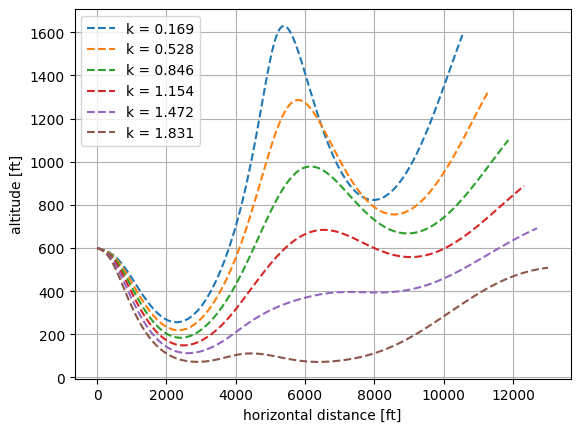

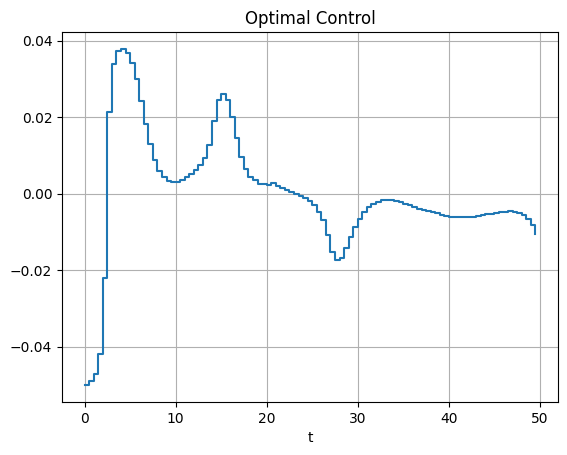

In [11]:
plot_multi_plane_2D(res_pce[0], nodes)